# USAD
## Importing packages

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score

## Reading data

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [66]:
seed_num = 439
set_seed(seed_num)

In [4]:
na_columns = ['2_LS_001_AL', '2_LS_002_AL', '2_P_001_STATUS', '2_P_002_STATUS', '1_LS_001_AL', '1_LS_001_AL', 'Row', 'Date', 'Time']

In [5]:
df = pd.read_csv('../../../Projects/data/WADI/WADI_14days_new.csv')
df.columns = df.columns.str.strip()
df = df.drop(columns=na_columns, inplace=False)
df = df.ffill(inplace=False)
df = df.astype('float')
grouping_array = np.arange(len(df)) // 5
df = df.groupby(grouping_array).median()
mm = StandardScaler()
df = pd.DataFrame(mm.fit_transform(df))
validation_set = df[int(df.shape[0] * 0.8):]
train_set = df[:int(df.shape[0] * 0.8)]

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
window_size = 10
input_size = window_size * 122
latent_space = 10 * window_size
epochs = 70

In [8]:
class SWat_dataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, target: pd.DataFrame,  window_size, device):
        self.data = dataframe
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        window = self.data[idx: idx + self.window_size]
        features = torch.tensor(window.iloc[:,:].values).float().to(device)
        return features

In [9]:
train_dataset = SWat_dataset(train_set, train_set, window_size, device)
validation_dataset = SWat_dataset(validation_set, validation_set, window_size, device)

batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

## Setting up the model structure

In [10]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(input_size, input_size // 2)
        self.relu = nn.ReLU(True)
        self.fc2 = nn.Linear(input_size // 2, input_size // 4)
        self.fc3 = nn.Linear(input_size // 4, hidden_size)
    
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        return out


class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, encoder):        
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU(True)
        self.fc1 = nn.Linear(hidden_size, input_size // 4)
        self.fc2 = nn.Linear(input_size // 4, input_size // 2)
        self.fc3 = nn.Linear(input_size // 2, input_size)
        
    def forward(self, x):
        out = self.encoder(x)
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [11]:
shared_encoder = Encoder(input_size, latent_space)
AE1 = AutoEncoder(input_size, latent_space, shared_encoder)
AE2 = AutoEncoder(input_size, latent_space, shared_encoder)

In [12]:
shared_encoder.to(device)
AE1.to(device)
AE2.to(device)

AutoEncoder(
  (encoder): Encoder(
    (fc1): Linear(in_features=1220, out_features=610, bias=True)
    (relu): ReLU(inplace=True)
    (fc2): Linear(in_features=610, out_features=305, bias=True)
    (fc3): Linear(in_features=305, out_features=100, bias=True)
  )
  (sigmoid): Sigmoid()
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=100, out_features=305, bias=True)
  (fc2): Linear(in_features=305, out_features=610, bias=True)
  (fc3): Linear(in_features=610, out_features=1220, bias=True)
)

In [13]:
optimizer1 = torch.optim.Adam(AE1.parameters())
optimizer2 = torch.optim.Adam(AE2.parameters())

In [67]:
model_path_AE1 = 'my_USAD_downsampled_AE1_hidden_10_seed_' + str(seed_num) + '.pth'
model_path_AE2 = 'my_USAD_downsampled_AE2_hidden_10_seed_' + str(seed_num) + '.pth'

## Training the model

### Training

In [14]:
%%time
AE1_val_history = []
AE2_val_history = []
for i in range(epochs):
    running_loss_AE1 = []
    running_loss_AE2 = []
    val_loss_AE1 = []
    val_loss_AE2 = []
    for index_b, features in enumerate(train_loader):
        features = features.view(features.shape[0], -1)
        
        w1 = AE1(features)
        w2 = AE2(features)
        w3 = AE2(w1)
        lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        
        running_loss_AE1.append(lossAE1)
        lossAE1.backward()
        optimizer1.step()
        optimizer1.zero_grad()
        
        w1 = AE1(features)
        w2 = AE2(features)
        w3 = AE2(w1)
        lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        
        running_loss_AE2.append(lossAE2)
        lossAE2.backward()
        optimizer2.step()
        optimizer2.zero_grad()
    
    for index_b, features in enumerate(validation_loader):
        with torch.no_grad():
            features = features.view(features.shape[0], -1)
        
            w1 = AE1(features)
            w2 = AE2(features)
            w3 = AE2(w1)
            lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
            lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
            val_loss_AE1.append(lossAE1)
            val_loss_AE2.append(lossAE2)
    AE1_val_history.append(torch.stack(val_loss_AE1).mean().item())
    AE2_val_history.append(torch.stack(val_loss_AE2).mean().item())
    print(f'Epoch: {i} ---> Val loss: AE1 {AE1_val_history[-1]:.4f}, AE2: {AE2_val_history[-1]:.4f}')
    print(f'Train loss: AE1 {torch.stack(running_loss_AE1).mean().item():.4f}, AE2 {torch.stack(running_loss_AE2).mean().item():.4f}')

Epoch: 0 ---> Val loss: AE1 0.5061, AE2: 0.5131
Train loss: AE1 0.4928, AE2 0.4946
Epoch: 1 ---> Val loss: AE1 0.6255, AE2: -0.0595
Train loss: AE1 0.4874, AE2 -0.0453
Epoch: 2 ---> Val loss: AE1 0.7388, AE2: -0.3760
Train loss: AE1 0.6752, AE2 -0.3194
Epoch: 3 ---> Val loss: AE1 0.7535, AE2: -0.5029
Train loss: AE1 0.6608, AE2 -0.4767
Epoch: 4 ---> Val loss: AE1 0.7579, AE2: -0.5605
Train loss: AE1 0.6638, AE2 -0.5419
Epoch: 5 ---> Val loss: AE1 0.7733, AE2: -0.6078
Train loss: AE1 0.6866, AE2 -0.5817
Epoch: 6 ---> Val loss: AE1 0.7725, AE2: -0.6401
Train loss: AE1 0.6840, AE2 -0.6089
Epoch: 7 ---> Val loss: AE1 0.7776, AE2: -0.6628
Train loss: AE1 0.6880, AE2 -0.6299
Epoch: 8 ---> Val loss: AE1 0.7797, AE2: -0.6816
Train loss: AE1 0.6924, AE2 -0.6445
Epoch: 9 ---> Val loss: AE1 0.7929, AE2: -0.6866
Train loss: AE1 0.7034, AE2 -0.6519
Epoch: 10 ---> Val loss: AE1 0.7858, AE2: -0.7036
Train loss: AE1 0.7179, AE2 -0.6601
Epoch: 11 ---> Val loss: AE1 0.7832, AE2: -0.7148
Train loss: AE1 

In [15]:
def plot_history(losses1, losses2):
    plt.plot(losses1, '-x', label="loss1")
    plt.plot(losses2, '-x', label="loss2")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Losses vs. No. of epochs')
    plt.grid()
    plt.show()

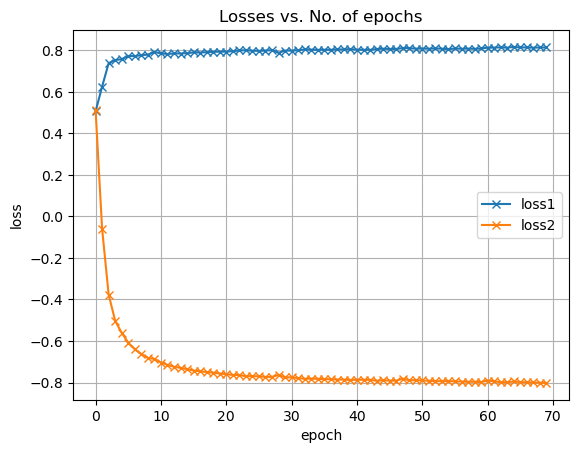

In [16]:
plot_history(AE1_val_history, AE2_val_history)

In [68]:
torch.save(AE1.state_dict(), model_path_AE1)
torch.save(AE2.state_dict(), model_path_AE2)

In [18]:
AE1.load_state_dict(torch.load(model_path_AE1))
AE2.load_state_dict(torch.load(model_path_AE2))

## Testing

In [19]:
df_test = pd.read_csv('../../../Projects/data/WADI/WADI_attackdataLABLE.csv')
df_test = df_test[:-2]
df_test.columns = df_test.columns.str.strip()
df_test = df_test.drop(columns=na_columns, inplace=False)
df_test = df_test.astype('float')
grouping_array = np.arange(len(df_test)) // 5
df_test = df_test.groupby(grouping_array).median()
labels = df_test['Attack LABLE (1:No Attack, -1:Attack)']
df_test = df_test.drop(columns=['Attack LABLE (1:No Attack, -1:Attack)'], inplace=False)
df_test = df_test.ffill(inplace=False)
df_test = df_test.astype('float')
test_normalized = pd.DataFrame(mm.fit_transform(df_test))

In [20]:
test_dataset = SWat_dataset(test_normalized, test_normalized, window_size, device)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [21]:
def testing(test_loader, alpha=.5, beta=.5):
    results=[]
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.view(batch.shape[0], -1)
            w1=AE1(batch)
            w2=AE2(w1)
            results.append(alpha*torch.mean((batch-w1)**2,axis=1)+beta*torch.mean((batch-w2)**2,axis=1))
    return results

In [22]:
labels = labels.values
labels = [0 if (lab == 1) else 1 for lab in labels]

In [23]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int32(labels[i:i+window_size])))

In [24]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels]

In [25]:
results=testing(test_loader)

In [26]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(), 
                       results[-1].flatten().detach().cpu().numpy()])

In [27]:
def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]

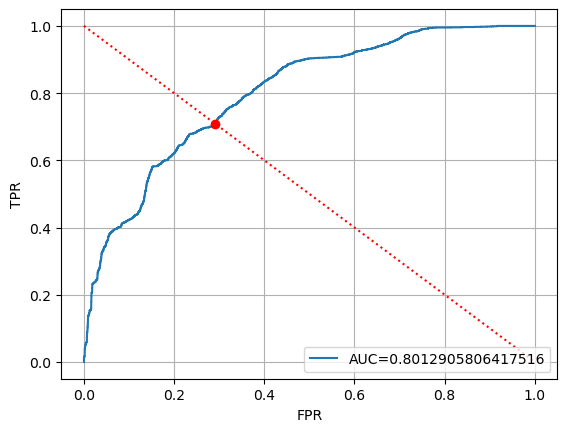

In [28]:
threshold = ROC(y_test,y_pred)

In [29]:
threshold

array([0.41606244], dtype=float32)

best: 1.5882352941176472 F1: 0.3385539583780305


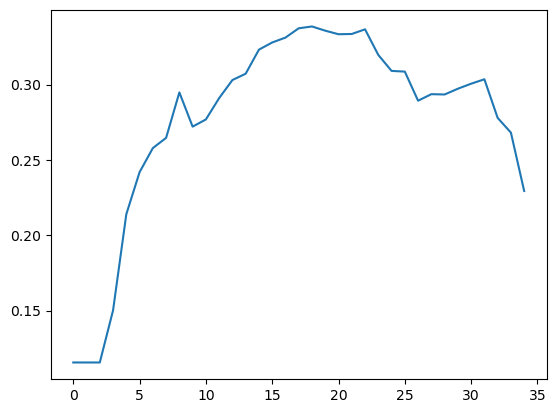

In [36]:
ff = 0
f_history = []
initial_y = 0
best = -1
for inc in np.linspace(0, 3, 35):
    y_pred_int = (y_pred > (initial_y + inc)).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc + initial_y
print(f'best: {best} F1: {ff}')
plt.plot(f_history)

In [60]:
np.sum(labels)

1993

In [62]:
len(y_pred)

34551

In [59]:
y_pred_int = np.array((y_pred > (initial_y + best)).astype(int))
latency_times = []
for index, (i, j) in enumerate(anomaly_segments):
    current_arr = y_pred_int[i: j]
    first_detection = np.where(current_arr == 1)[0]
    print(f'First detection of aomaly_segment number {index} is: {first_detection}')
    if first_detection.shape[0] > 0:
        latency_times.append(first_detection[0])
print(np.mean(latency_times))

First detection of aomaly_segment number 0 is: []
First detection of aomaly_segment number 1 is: [38 39 40 41 42 43 44 45 46 47 69 70 71 72 73 74 75 76 77 78 79 80 81 82]
First detection of aomaly_segment number 2 is: [ 43  44  45  46  47  48  49  50  51  52  53  54  55 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194
 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212
 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230
 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248
 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266
 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284
 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302
 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320
 321 322 323 324 325 326 327 328 329 330 331 332 333

# Try adjust point

In [31]:
labels = labels[window_size:]
started = False
anomaly_segments = []
for i in range(len(labels)):
    if labels[i] == 1 and not started:
        started = True
        left_side = i
    if labels[i] == 0 and started:
        started = False
        anomaly_segments.append((left_side, i - 1))

## Point Adjust

best: 2.2448979591836737 F1: 0.6013921113689095


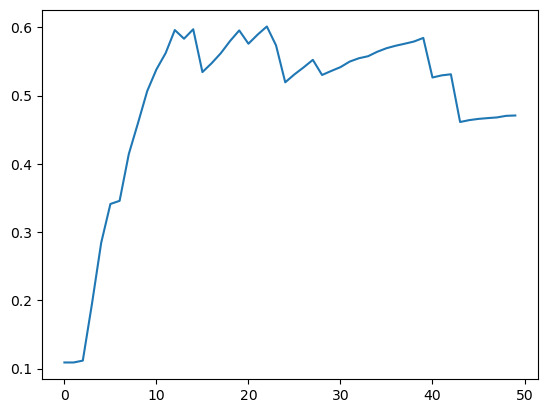

In [65]:
ff = 0
f_history = []
initial_y = 0
best = -1
for inc in np.linspace(0, 5, 50):
    y_pred_int = (y_pred > initial_y + inc).astype(int)
    for i, j in anomaly_segments:
        if np.sum(y_pred_int[i: j]) > 0:
            y_pred_int[i:j + 1] = [1 for _ in range(j - i + 1)]
    conf_matrix = confusion_matrix(labels, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(labels, y_pred_int)
    f_history.append(F1)

    precision = precision_score(labels, y_pred_int)
    recall = recall_score(labels, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc + initial_y
print(f'best: {best} F1: {ff}')
plt.plot(f_history)

## Point Adjust 20%

best: 1.9387755102040818 F1: 0.43967093235831806


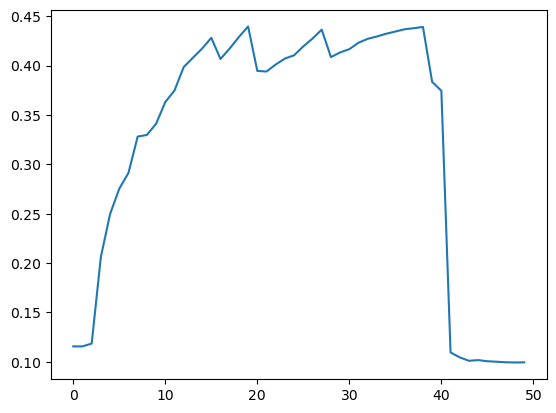

In [34]:
ff = 0
f_history = []
initial_y = 0
best = -1
for inc in np.linspace(0, 5, 50):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    for i, j in anomaly_segments:
        if np.sum(y_pred_int[i: j]) / (j - i) > 0.2:
            y_pred_int[i:j + 1] = [1 for _ in range(j - i + 1)]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc + initial_y
print(f'best: {best} F1: {ff}')
plt.plot(f_history)

## Visualization

In [ ]:
x_vals = 0. + np.linspace(0, 20, 50)
plt.plot(x_vals, f_history)
plt.xlabel('Threshold')
plt.ylabel('F1 score')

max_y = max(f_history)
max_x = np.argmax(f_history)
plt.axhline(y=max_y, color='r', linestyle='--', label='Max Y')
plt.text(0.6, max_y + 0.05, f'Max F1= {max_y: .4f}', color='r')
plt.ylim(0, 1)
plt.grid(True)

# plt.savefig('my_plot.png')

plt.show()

In [ ]:
sum1 = sum(p.numel() for p in AE1.parameters() if p.requires_grad)
sum2 = sum(p.numel() for p in AE2.parameters() if p.requires_grad)
sum3 = sum(p.numel() for p in shared_encoder.parameters() if p.requires_grad)
print(sum1 + sum2 - sum3)